In this notebook, we use pyspark to explore a [dataset](https://data.sfgov.org/Public-Safety/sf-data/skgt-fej3/data) from the San Francisco Police Department

In [1]:
from csv import reader
from pyspark.sql import Row
from pyspark.sql.types import *  

In [2]:
# read the data
crime_data_lines = sc.textFile('sf_data.csv') 
df_crimes = crime_data_lines.map(lambda line: [x.strip('"') for x in next(reader([line]))])

In [3]:
## Extract header
header = df_crimes.first()
header

['IncidntNum',
 'Category',
 'Descript',
 'DayOfWeek',
 'Date',
 'Time',
 'PdDistrict',
 'Resolution',
 'Address',
 'X',
 'Y',
 'Location',
 'PdId']

In [4]:
# get anyting but the header 
crimes = df_crimes.filter(lambda x: x != header)
crimes.take(2) # check two rows

[['179005317',
  'OTHER OFFENSES',
  'FALSE PERSONATION TO RECEIVE MONEY OR PROPERTY',
  'Tuesday',
  '07/11/2017',
  '14:32',
  'SOUTHERN',
  'NONE',
  '800 Block of BRYANT ST',
  '-122.40340479147905',
  '37.775420706711',
  '(37.775420706711, -122.40340479147905)',
  '17900531709029'],
 ['179005210',
  'FORGERY/COUNTERFEITING',
  'MANUFACTURE OR SALE OF COUNTERFEIT GOODS',
  'Tuesday',
  '07/11/2017',
  '17:27',
  'SOUTHERN',
  'NONE',
  '800 Block of BRYANT ST',
  '-122.40340479147905',
  '37.775420706711',
  '(37.775420706711, -122.40340479147905)',
  '17900521009261']]

Now let's transform the RDD to data frame, which would be easier to handle and explore. First, we need to convert RDD elements to RDD **Row** objects. We can define a function below to take a list of column names (header) and a list of values (one row of our data) and then create a RDD Row of key-value pairs.

In [5]:
def list_to_row(keys, values):
    row_dict = dict(zip(keys, values))
    return Row(**row_dict) # use ** to unpack the dictionary to become "key = value" pairs

We can now use ``map`` and the function defined above to convert all the rows of our data to RDD Row objects, and then we can create a data frame using ``spark.createDataFrame``.

In [6]:
rdd_rows = crimes.map(lambda x: list_to_row(header, x))
df = spark.createDataFrame(rdd_rows)

In [7]:
# take a look at the data frame
df.show()

+--------------------+--------------------+----------+---------+--------------------+----------+--------------------+----------+--------------+--------------+-----+-------------------+------------------+
|             Address|            Category|      Date|DayOfWeek|            Descript|IncidntNum|            Location|PdDistrict|          PdId|    Resolution| Time|                  X|                 Y|
+--------------------+--------------------+----------+---------+--------------------+----------+--------------------+----------+--------------+--------------+-----+-------------------+------------------+
|800 Block of BRYA...|      OTHER OFFENSES|07/11/2017|  Tuesday|FALSE PERSONATION...| 179005317|(37.775420706711,...|  SOUTHERN|17900531709029|          NONE|14:32|-122.40340479147905|   37.775420706711|
|800 Block of BRYA...|FORGERY/COUNTERFE...|07/11/2017|  Tuesday|MANUFACTURE OR SA...| 179005210|(37.775420706711,...|  SOUTHERN|17900521009261|          NONE|17:27|-122.40340479147905|

In [8]:
# replace two column names, "X" and "Y", with "Longitude" and "Latitude", and also
# change their types to float
df = df.withColumn('X', df['X'].cast('float')).withColumn('Y', df['Y'].cast('float'))
df = df.withColumnRenamed('X','Longitude').withColumnRenamed('Y','Latitude')

In [9]:
# inspect the schema of the data frame
df.printSchema()

root
 |-- Address: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- Descript: string (nullable = true)
 |-- IncidntNum: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- PdDistrict: string (nullable = true)
 |-- PdId: string (nullable = true)
 |-- Resolution: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Longitude: float (nullable = true)
 |-- Latitude: float (nullable = true)



Now we can explore the dataset. Let's count the number of incidents for each category.

In [10]:
# Method 1: SQL
df.createOrReplaceTempView("crime")
sqlDF = spark.sql("select Category, count(*) as Count from crime group by Category order by Count desc")
sqlDF.show(40, False)

+---------------------------+-----+
|Category                   |Count|
+---------------------------+-----+
|LARCENY/THEFT              |2804 |
|OTHER OFFENSES             |1002 |
|NON-CRIMINAL               |988  |
|ASSAULT                    |780  |
|VANDALISM                  |650  |
|VEHICLE THEFT              |353  |
|SUSPICIOUS OCC             |311  |
|WARRANTS                   |309  |
|BURGLARY                   |300  |
|MISSING PERSON             |263  |
|ROBBERY                    |187  |
|DRUG/NARCOTIC              |167  |
|FRAUD                      |155  |
|SECONDARY CODES            |118  |
|TRESPASS                   |109  |
|WEAPON LAWS                |106  |
|STOLEN PROPERTY            |66   |
|RECOVERED VEHICLE          |48   |
|RUNAWAY                    |39   |
|SEX OFFENSES, FORCIBLE     |39   |
|FORGERY/COUNTERFEITING     |29   |
|ARSON                      |29   |
|PROSTITUTION               |20   |
|DRUNKENNESS                |19   |
|DISORDERLY CONDUCT         

In [11]:
# Method 2: Data Frame
df.groupBy("Category").count().orderBy("count", ascending=False).show(40, False)

+---------------------------+-----+
|Category                   |count|
+---------------------------+-----+
|LARCENY/THEFT              |2804 |
|OTHER OFFENSES             |1002 |
|NON-CRIMINAL               |988  |
|ASSAULT                    |780  |
|VANDALISM                  |650  |
|VEHICLE THEFT              |353  |
|SUSPICIOUS OCC             |311  |
|WARRANTS                   |309  |
|BURGLARY                   |300  |
|MISSING PERSON             |263  |
|ROBBERY                    |187  |
|DRUG/NARCOTIC              |167  |
|FRAUD                      |155  |
|SECONDARY CODES            |118  |
|TRESPASS                   |109  |
|WEAPON LAWS                |106  |
|STOLEN PROPERTY            |66   |
|RECOVERED VEHICLE          |48   |
|SEX OFFENSES, FORCIBLE     |39   |
|RUNAWAY                    |39   |
|FORGERY/COUNTERFEITING     |29   |
|ARSON                      |29   |
|PROSTITUTION               |20   |
|DRUNKENNESS                |19   |
|DISORDERLY CONDUCT         

In [12]:
# Method 3: Just use the functions of RDD
rdd = crimes.map(lambda line: (line[1],1))
sorted(rdd.countByKey().items(), key = lambda x: -x[1])

[('LARCENY/THEFT', 2804),
 ('OTHER OFFENSES', 1002),
 ('NON-CRIMINAL', 988),
 ('ASSAULT', 780),
 ('VANDALISM', 650),
 ('VEHICLE THEFT', 353),
 ('SUSPICIOUS OCC', 311),
 ('WARRANTS', 309),
 ('BURGLARY', 300),
 ('MISSING PERSON', 263),
 ('ROBBERY', 187),
 ('DRUG/NARCOTIC', 167),
 ('FRAUD', 155),
 ('SECONDARY CODES', 118),
 ('TRESPASS', 109),
 ('WEAPON LAWS', 106),
 ('STOLEN PROPERTY', 66),
 ('RECOVERED VEHICLE', 48),
 ('SEX OFFENSES, FORCIBLE', 39),
 ('RUNAWAY', 39),
 ('ARSON', 29),
 ('FORGERY/COUNTERFEITING', 29),
 ('PROSTITUTION', 20),
 ('DRUNKENNESS', 19),
 ('DISORDERLY CONDUCT', 18),
 ('DRIVING UNDER THE INFLUENCE', 16),
 ('KIDNAPPING', 10),
 ('BRIBERY', 7),
 ('EMBEZZLEMENT', 5),
 ('LOITERING', 4),
 ('LIQUOR LAWS', 4),
 ('SUICIDE', 3),
 ('EXTORTION', 2),
 ('SEX OFFENSES, NON FORCIBLE', 1),
 ('PORNOGRAPHY/OBSCENE MAT', 1),
 ('TREA', 1),
 ('FAMILY OFFENSES', 1)]

How about the number of incidents at each district?

In [13]:
# Method 1: SQL
sqlDF = spark.sql("select PdDistrict, count(*) as Count from crime group by PdDistrict order by Count desc")
sqlDF.show()

+----------+-----+
|PdDistrict|Count|
+----------+-----+
|  SOUTHERN| 1743|
|   MISSION| 1190|
|  NORTHERN| 1169|
|   CENTRAL| 1137|
|   BAYVIEW|  816|
| INGLESIDE|  670|
|   TARAVAL|  660|
|TENDERLOIN|  535|
|  RICHMOND|  527|
|      PARK|  517|
+----------+-----+



In [14]:
# Method 2: Data Frame
df.groupBy("PdDistrict").count().orderBy("count", ascending=False).show()

+----------+-----+
|PdDistrict|count|
+----------+-----+
|  SOUTHERN| 1743|
|   MISSION| 1190|
|  NORTHERN| 1169|
|   CENTRAL| 1137|
|   BAYVIEW|  816|
| INGLESIDE|  670|
|   TARAVAL|  660|
|TENDERLOIN|  535|
|  RICHMOND|  527|
|      PARK|  517|
+----------+-----+



In [15]:
# Method 3: Just use the functions of RDD
rdd = crimes.map(lambda line: (line[6],1))
sorted(rdd.countByKey().items(), key = lambda x: -x[1])

[('SOUTHERN', 1743),
 ('MISSION', 1190),
 ('NORTHERN', 1169),
 ('CENTRAL', 1137),
 ('BAYVIEW', 816),
 ('INGLESIDE', 670),
 ('TARAVAL', 660),
 ('TENDERLOIN', 535),
 ('RICHMOND', 527),
 ('PARK', 517)]

With the latitude and longitude, we can count the number of incidents within a certain area we define. Let's count the number of incidents each Sunday at SF downtown. Here I define "downtown" as an area within 0.005 degree from (Lat, Long) = (37.792489, -122.403221). This area roughly includes Financial District, China Town and Union Square.

In [16]:
# Method 1: SQL
sqlDF = spark.sql("select Date, DayOfWeek, count(*) as Count from crime \
                   where DayOfWeek = 'Sunday' and \
                   pow(Latitude - 37.792489, 2) + pow(Longitude + 122.403221, 2) < pow(0.005, 2) \
                   group by Date, DayOfWeek order by Date")
sqlDF.show()

+----------+---------+-----+
|      Date|DayOfWeek|Count|
+----------+---------+-----+
|07/16/2017|   Sunday|   10|
|07/23/2017|   Sunday|   20|
|07/30/2017|   Sunday|   14|
+----------+---------+-----+



In [17]:
# Method 2: Data Frame
df_downtown = df.filter((df['Latitude'] - 37.792489)**2 + (df['Longitude'] + 122.403221)**2 < 0.005**2)
df_downtown.filter(df_downtown['DayOfWeek'] == 'Sunday').groupBy("Date", "DayOfWeek").count().orderBy('Date').show()

+----------+---------+-----+
|      Date|DayOfWeek|count|
+----------+---------+-----+
|07/16/2017|   Sunday|   10|
|07/23/2017|   Sunday|   20|
|07/30/2017|   Sunday|   14|
+----------+---------+-----+



Lastly, let's visualize the spatial distribution of the crimes and run a kmeans clustering algorithm using the [pyspark.ml](http://spark.apache.org/docs/2.0.0/api/python/pyspark.ml.html) library.

In [18]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
import seaborn as sns

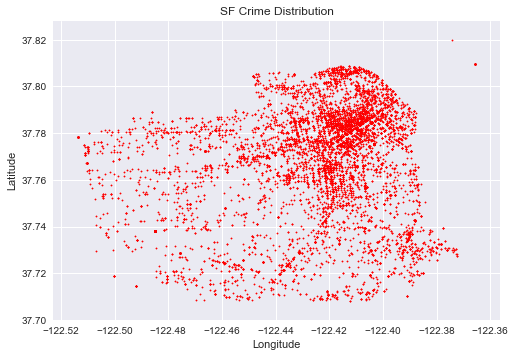

In [19]:
# make a scatter plot to show the spatial distribution of incidents
pdf = df[['Longitude','Latitude']].toPandas()
fig = plt.figure()
plt.title('SF Crime Distribution')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(pdf.Longitude, pdf.Latitude, s = 2, c = 'r')
plt.show()

We can see there are a lot more crimes in the north-eastern part of SF!

Spark ML requires the input features to be lists that are stored in a single column, usually named "features", so we need to use [VectorAssembler](http://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html#pyspark.ml.feature.VectorAssembler) to do this transformation for our Longitude and Latitude

In [20]:
df_coor = df[['Longitude','Latitude']]
vecAssembler = VectorAssembler(inputCols=["Longitude", "Latitude"], outputCol="features")
new_df = vecAssembler.transform(df_coor)[['features']]
new_df.show(10,False)

+----------------------------------------+
|features                                |
+----------------------------------------+
|[-122.40340423583984,37.775421142578125]|
|[-122.40340423583984,37.775421142578125]|
|[-122.40340423583984,37.775421142578125]|
|[-122.40340423583984,37.775421142578125]|
|[-122.40340423583984,37.775421142578125]|
|[-122.40340423583984,37.775421142578125]|
|[-122.47869873046875,37.72821044921875] |
|[-122.39410400390625,37.77638244628906] |
|[-122.414306640625,37.800758361816406]  |
|[-122.3958511352539,37.78132247924805]  |
+----------------------------------------+
only showing top 10 rows



Now we can fit a kmeans model to ``new_df``

In [21]:
# train a kmeans model
kmeans = KMeans().setK(3).setSeed(1) # just a arbitrary choice of k... 
model = kmeans.fit(new_df)

# show the results
centers = model.clusterCenters()
print "Cluster Centers: "
for center in centers:
    print center

print "\nMemberships: "
transformed = model.transform(new_df)
transformed.show()    

Cluster Centers: 
[-122.40974769   37.73798359]
[-122.4724593    37.75483376]
[-122.41480275   37.78269368]

Memberships: 
+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[-122.40340423583...|         2|
|[-122.40340423583...|         2|
|[-122.40340423583...|         2|
|[-122.40340423583...|         2|
|[-122.40340423583...|         2|
|[-122.40340423583...|         2|
|[-122.47869873046...|         1|
|[-122.39410400390...|         2|
|[-122.41430664062...|         2|
|[-122.39585113525...|         2|
|[-122.41181182861...|         0|
|[-122.38874053955...|         2|
|[-122.40560913085...|         0|
|[-122.43531799316...|         2|
|[-122.40340423583...|         2|
|[-122.43798065185...|         2|
|[-122.43183135986...|         2|
|[-122.40340423583...|         2|
|[-122.47329711914...|         1|
|[-122.39929199218...|         2|
+--------------------+----------+
only showing top 20 rows



Let's visualize the results

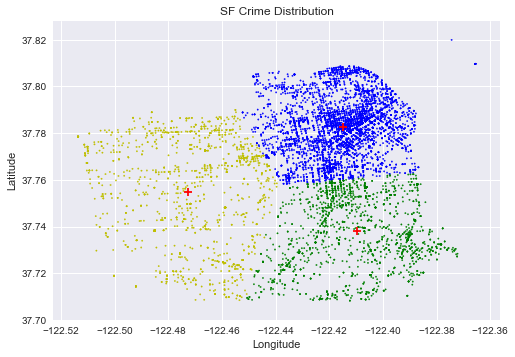

In [22]:
# cluster centers
long_centers = [i for i, _ in centers]
lat_centers = [i for _, i in centers]

# assign colors for each data points based on their memberships
memberships = transformed.toPandas().loc[:,'prediction'].values
clusters2colors = {0: 'g', 1: 'y', 2: 'b'}
colors = [clusters2colors[i] for i in memberships]

fig = plt.figure()
plt.title('SF Crime Distribution')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(pdf.Longitude, pdf.Latitude, s = 2, c=colors)
plt.scatter(long_centers, lat_centers, s = 50, c = 'r', marker = '+')
plt.show()